In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BernoulliBandit:
    def __init__(self, K):
        # 生成K根杆子的概率分布 伯努利分布
        self.probs = np.random.uniform(size=K)
        # 能获得奖励概率最大的分布的下标
        self.best_idx = np.argmax(self.probs)
        # 能获得奖励最大的概率
        self.best_prob = self.probs[self.best_idx]
        self.K = K
        
    
    def step(self, k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

In [3]:
# 设置随机种子
np.random.seed(2)

# 假设有十根杆子
bandit = BernoulliBandit(10)    

In [ ]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        # 每根拉杆的次数
        self.counts = np.zeros(self.bandit.K)
        # 累计懊悔
        self.regret = 0
        # 每一根杆子当前的奖励期望
        self.Qs = np.zeros(self.bandit.K)
        # 当前奖励期望最大杆子的下标
        self.max_q_idx = np.argmax(self.Qs)
        # 当前最大的奖励期望
        self.max_q = self.Qs[self.max_q_idx]
        
    

In [8]:
class MultiArmedBandit:
    def __init__(self, arms, means, std_devs):
        """
        arms: 整数，表示老虎机手臂的数量。
        means: 列表或数组，包含每个手臂奖励的均值。
        std_devs: 列表或数组，包含每个手臂奖励的标准差。
        """
        self.arms = arms
        self.means = means
        self.std_devs = std_devs
        self.n_pulls = np.zeros(self.arms)  # 记录每个手臂被拉的次数

    def pull_arm(self, arm):
        """
        拉指定的手臂并返回奖励。
        """
        return np.random.normal(self.means[arm], self.std_devs[arm])

    def update(self, arm, reward):
        """
        更新手臂被拉的次数。
        """
        self.n_pulls[arm] += 1

def epsilon_greedy(bandit, epsilon, n_trials):
    """
    实现ϵ-贪心算法。

    bandit: MultiArmedBandit的实例。
    epsilon: 探索的概率。
    n_trials: 要进行的试验总数。
    """
    total_reward = 0
    for trial in range(n_trials):
        if np.random.rand() < epsilon:  # 探索
            arm = np.random.choice(bandit.arms)
        else:  # 利用
            # 选择当前估计奖励最高的手臂
            arm = np.argmax(bandit.n_pulls * bandit.means - 2.0 * np.sqrt(bandit.n_pulls) * bandit.std_devs)
        reward = bandit.pull_arm(arm)
        bandit.update(arm, reward)
        total_reward += reward
    return total_reward

# 定义每个手臂的均值和标准差
means = [ 0.5, 0.3, 0.2]
std_devs = [0.1, 0.1, 0.1]
arms = len(means)

# 创建多臂老虎机实例
bandit = MultiArmedBandit(arms, means, std_devs)

# 进行试验
epsilon = 0.1
n_trials = 10000
total_reward = epsilon_greedy(bandit, epsilon, n_trials)

print(f"Total reward after {n_trials} trials: {total_reward}")

Total reward after 10000 trials: 4821.641734556396


In [1]:
import numpy as np

class MultiArmedBandit:
    def __init__(self, probabilities):
        # 每个老虎机的成功概率
        self.probabilities = probabilities
        self.K = len(probabilities)
    
    def pull(self, arm):
        # 根据指定老虎机的成功概率，返回奖励（0或1）
        return 1 if np.random.random() < self.probabilities[arm] else 0

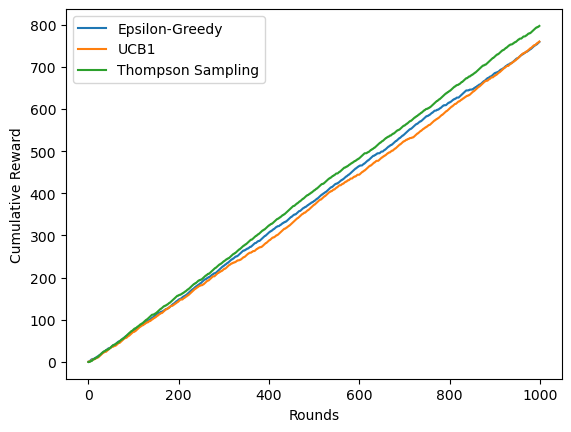

In [10]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # 每个臂被选择的次数
        self.values = np.zeros(n_arms)  # 每个臂的平均奖励

    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)  # 随机探索
        else:
            return np.argmax(self.values)  # 选择目前最优的臂
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        # 更新指定臂的平均奖励
        n = self.counts[arm]
        self.values[arm] = self.values[arm] + (reward - self.values[arm]) / n


class UCB1:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # 每个臂被选择的次数
        self.values = np.zeros(n_arms)  # 每个臂的平均奖励
        self.total_counts = 0

    def select_arm(self):
        if 0 in self.counts:
            return np.argmin(self.counts)  # 确保每个臂至少被选过一次
        ucb_values = self.values + np.sqrt(2 * np.log(self.total_counts) / self.counts)
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.total_counts += 1
        # 更新指定臂的平均奖励
        n = self.counts[arm]
        self.values[arm] = self.values[arm] + (reward - self.values[arm]) / n


class ThompsonSampling:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        # 初始化贝塔分布的参数
        self.successes = np.zeros(n_arms)
        self.failures = np.zeros(n_arms)
    
    def select_arm(self):
        # 为每个臂从 Beta 分布中采样
        sampled_values = np.random.beta(self.successes + 1, self.failures + 1)
        return np.argmax(sampled_values)
    
    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1


def run_experiment(bandit, algorithm, n_rounds=1000):
    rewards = np.zeros(n_rounds)
    for i in range(n_rounds):
        arm = algorithm.select_arm()
        reward = bandit.pull(arm)
        algorithm.update(arm, reward)
        rewards[i] = reward
    return rewards

# 创建一个多臂老虎机环境，假设有3个老虎机，概率分别为0.2, 0.5, 0.8
bandit = MultiArmedBandit([0.2, 0.5, 0.8])

# 实验轮数
n_rounds = 1000

# ε-Greedy
epsilon_greedy = EpsilonGreedy(n_arms=3, epsilon=0.1)
rewards_epsilon_greedy = run_experiment(bandit, epsilon_greedy, n_rounds)

# UCB1
ucb1 = UCB1(n_arms=3)
rewards_ucb1 = run_experiment(bandit, ucb1, n_rounds)

# 汤普森采样
thompson_sampling = ThompsonSampling(n_arms=3)
rewards_thompson_sampling = run_experiment(bandit, thompson_sampling, n_rounds)

# 计算累积奖励
cumulative_rewards_epsilon = np.cumsum(rewards_epsilon_greedy)
cumulative_rewards_ucb1 = np.cumsum(rewards_ucb1)
cumulative_rewards_thompson = np.cumsum(rewards_thompson_sampling)

import matplotlib.pyplot as plt

plt.plot(cumulative_rewards_epsilon, label='Epsilon-Greedy')
plt.plot(cumulative_rewards_ucb1, label='UCB1')
plt.plot(cumulative_rewards_thompson, label='Thompson Sampling')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()
